# Chapter 3 - Backpropagation

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [9]:
paris_coords = np.array([
    [48.8575, 2.3514], #Center of Paris
    [48.8584, 2.2945], # Eiffel Tower
    [48.8530, 2.3499], #Notre Dame
    [48.8606,  2.3376], #Louvre
    [48.8606, 2.3522]  #Centre Pompidou
])

madrid_coords = np.array([
    [40.4167, -3.7033],   # Center of Madrid
    [40.4153, -3.6835],   # Retiro Park 
    [40.4180, -3.7143],   # Royal Palace 
    [40.4138, -3.6921],   # Prado Museum 
    [40.4169, -3.7033]   # Puerta del Sol 
])

berlin_coords = np.array([
    [52.5200, 13.4050], # Center of Berlin
    [52.5163, 13.3777],   # Brandenburg Gate 
    [52.5169, 13.4019],   # Museum Island 
    [52.5074, 13.3904],   # Checkpoint Charlie 
    [52.5251, 13.3694]   # Berlin Central Station 
])

In [10]:
# Set random seed for reproducibility
random_seed=52
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [11]:
# Combine data into one matrix X and labels y
X_raw = np.vstack([madrid_coords, paris_coords, berlin_coords]) 
y = np.array([0, 0, 0, 0, 0,  #  Madrid labels (0)
              1, 1, 1, 1, 1,  #  Paris labels (1)
              2, 2, 2, 2, 2]) #, # Berlin labels (2)

shuffle_idx = np.random.permutation(len(y))
X = X_raw[shuffle_idx, 1:2]  # Extract longitude as column vector
y = y[shuffle_idx]

In [12]:
X.shape, y.shape

((15, 1), (15,))

In [21]:
class TinyGPSModel(torch.nn.Module):
    def __init__(self, input_size=1, output_size=3):
        super(TinyGPSModel, self).__init__()
        self.output = torch.nn.Linear(input_size, output_size) 

    def forward(self, x):
        x = self.output(x)
        return x

In [50]:
# Initialize model, loss, and optimizer
model = TinyGPSModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

#Manually intialize model parameters
with torch.no_grad():
    model.output.weight[0,0]=1.0
    model.output.weight[1,0]=0.0
    model.output.weight[2,0]=-1.0
    model.output.bias[0]=0
    model.output.bias[1]=0
    model.output.bias[2]=0

for i in range(100):
    optimizer.zero_grad()
    outputs = model(torch.tensor(X[i%len(y)]).float())
    loss = criterion(outputs, torch.tensor(y[i%len(y)])) 

    loss.backward()  
    optimizer.step()
    
    with torch.no_grad():
        logits=model(torch.tensor(X, dtype=torch.float)) 
        accuracy=(torch.argmax(logits, dim=1)==torch.tensor(y)).sum().item()/len(y)
    print(f"Step {i+1}/{i}, Loss: {loss.item():.4f}, 'Accuracy: {accuracy:.4f}")

Step 1/0, Loss: 2.4382, 'Accuracy: 0.0000
Step 2/1, Loss: 7.0817, 'Accuracy: 0.0000
Step 3/2, Loss: 5.6146, 'Accuracy: 0.0000
Step 4/3, Loss: 15.8103, 'Accuracy: 0.6667
Step 5/4, Loss: 0.8223, 'Accuracy: 0.6667
Step 6/5, Loss: 0.6012, 'Accuracy: 0.6667
Step 7/6, Loss: 0.4003, 'Accuracy: 0.6667
Step 8/7, Loss: 2.2899, 'Accuracy: 0.3333
Step 9/8, Loss: 0.7958, 'Accuracy: 0.6667
Step 10/9, Loss: 0.0000, 'Accuracy: 0.6667
Step 11/10, Loss: 2.3400, 'Accuracy: 0.6667
Step 12/11, Loss: 1.9132, 'Accuracy: 0.6667
Step 13/12, Loss: 0.0007, 'Accuracy: 0.6667
Step 14/13, Loss: 0.0007, 'Accuracy: 0.6667
Step 15/14, Loss: 1.5043, 'Accuracy: 0.6667
Step 16/15, Loss: 1.1684, 'Accuracy: 0.6667
Step 17/16, Loss: 0.1639, 'Accuracy: 0.6667
Step 18/17, Loss: 0.1400, 'Accuracy: 0.6667
Step 19/18, Loss: 0.0763, 'Accuracy: 0.6667
Step 20/19, Loss: 1.0069, 'Accuracy: 0.6667
Step 21/20, Loss: 0.1124, 'Accuracy: 0.7333
Step 22/21, Loss: 0.0983, 'Accuracy: 1.0000
Step 23/22, Loss: 0.1678, 'Accuracy: 0.6667
Step 2

## Version with Instrumentation

I should move this notebook over to my standard manim repo, I don't think this needs to be here!

In [56]:
# Initialize model, loss, and optimizer
model = TinyGPSModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

with torch.no_grad():
    model.output.weight[0,0]=1.0
    model.output.weight[1,0]=0.0
    model.output.weight[2,0]=-1.0
    model.output.bias[0]=0
    model.output.bias[1]=0
    model.output.bias[2]=0

weights=[]
grads=[]
xs=[]
ys=[]
logitss=[]
yhats=[]
losses=[]
accuracies=[]

# Training loop
for i in range(100):
    xs.append(X_raw[i%len(y)])
    ys.append(y[i%len(y)])
    weights.append(np.concatenate([model.output.weight.detach().numpy().ravel(), model.output.bias.detach().numpy().ravel()]))
    
    optimizer.zero_grad()
    
    outputs = model(torch.tensor(X[i%len(y)]).float())
    loss = criterion(outputs, torch.tensor(y[i%len(y)])) 

    logitss.append(outputs.detach().numpy())
    yhats.append(torch.nn.Softmax(0)(outputs.detach()).numpy())

    #Heatmaps
    # heatmaps=[np.zeros((num_steps, num_steps)) for i in range(6)]
    # for j, lat in enumerate(np.linspace(max_lat, min_lat, num_steps)):
    #     for k, long in enumerate(np.linspace(min_long, max_long, num_steps)):
    #         with torch.no_grad():
    #             logits=model(torch.tensor([long], dtype=torch.float)).detach()
    #             yhat=torch.nn.Softmax(0)(heatmap_viz_logit_multiplier*logits).numpy()
    
    #         for l in range(3):
    #             heatmaps[l][j, k]=logits.numpy()[l]
    #             heatmaps[l+3][j,k]=yhat[l]

    # for l in range(6):
    #     plt.clf()
    #     plt.figure(frameon=False)
    #     ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
    #     ax.set_axis_off()
    #     plt.gcf().add_axes(ax)
    #     plt.imshow(heatmaps[l],  cmap=cmaps[l]) #np.rot90(heatmaps[0])) #Wait and see if I need to rotate or transpose
    #     plt.savefig(save_dir+'/'+str(i)+save_names[l], bbox_inches='tight', pad_inches=0, dpi=300)
    #     plt.close()

    
    
    loss.backward()  # backpropagation
    grads.append(np.concatenate([model.output.weight.grad.detach().numpy().ravel(), model.output.bias.grad.detach().numpy().ravel()]))
    losses.append(loss.item())
    optimizer.step() #

    
    with torch.no_grad():
        logits=model(torch.tensor(X, dtype=torch.float)) 
        accuracy=(torch.argmax(logits, dim=1)==torch.tensor(y)).sum().item()/len(y)
    print(f"Step {i+1}/{i}, Loss: {loss.item():.4f}, 'Accuracy: {accuracy:.4f}")
    accuracies.append(accuracy)

weights=np.array(weights)
grads=np.array(grads)
xs=np.array(xs)
ys=np.array(ys)
logitss=np.array(logitss)
yhats=np.array(yhats)
losses=np.array(losses)
accuracies=np.array(accuracies)

Step 1/0, Loss: 2.4382, 'Accuracy: 0.0000
Step 2/1, Loss: 7.4258, 'Accuracy: 0.0000
Step 3/2, Loss: 7.0293, 'Accuracy: 0.0000
Step 4/3, Loss: 24.5284, 'Accuracy: 0.0000
Step 5/4, Loss: 1.6606, 'Accuracy: 0.0000
Step 6/5, Loss: 6.0631, 'Accuracy: 0.0000
Step 7/6, Loss: 5.8054, 'Accuracy: 0.0000
Step 8/7, Loss: 20.5003, 'Accuracy: 0.0000
Step 9/8, Loss: 5.1647, 'Accuracy: 0.0000
Step 10/9, Loss: 18.4130, 'Accuracy: 0.0000
Step 11/10, Loss: 0.9263, 'Accuracy: 0.0000
Step 12/11, Loss: 0.8329, 'Accuracy: 0.0000
Step 13/12, Loss: 15.3987, 'Accuracy: 0.3333
Step 14/13, Loss: 14.5006, 'Accuracy: 0.3333
Step 15/14, Loss: 0.6168, 'Accuracy: 0.3333
Step 16/15, Loss: 0.5710, 'Accuracy: 0.3333
Step 17/16, Loss: 2.9934, 'Accuracy: 0.3333
Step 18/17, Loss: 2.7593, 'Accuracy: 0.3333
Step 19/18, Loss: 10.9580, 'Accuracy: 0.3333
Step 20/19, Loss: 0.4497, 'Accuracy: 0.3333
Step 21/20, Loss: 2.1426, 'Accuracy: 0.3333
Step 22/21, Loss: 1.9649, 'Accuracy: 0.3333
Step 23/22, Loss: 8.1768, 'Accuracy: 0.3333
S

Best way to to get these into a table in in Design?

In [117]:
BLUE='#21409a'
RED='#ed1c24'
GREEN='#00a14b'
CHILL_BROWN='#948979'

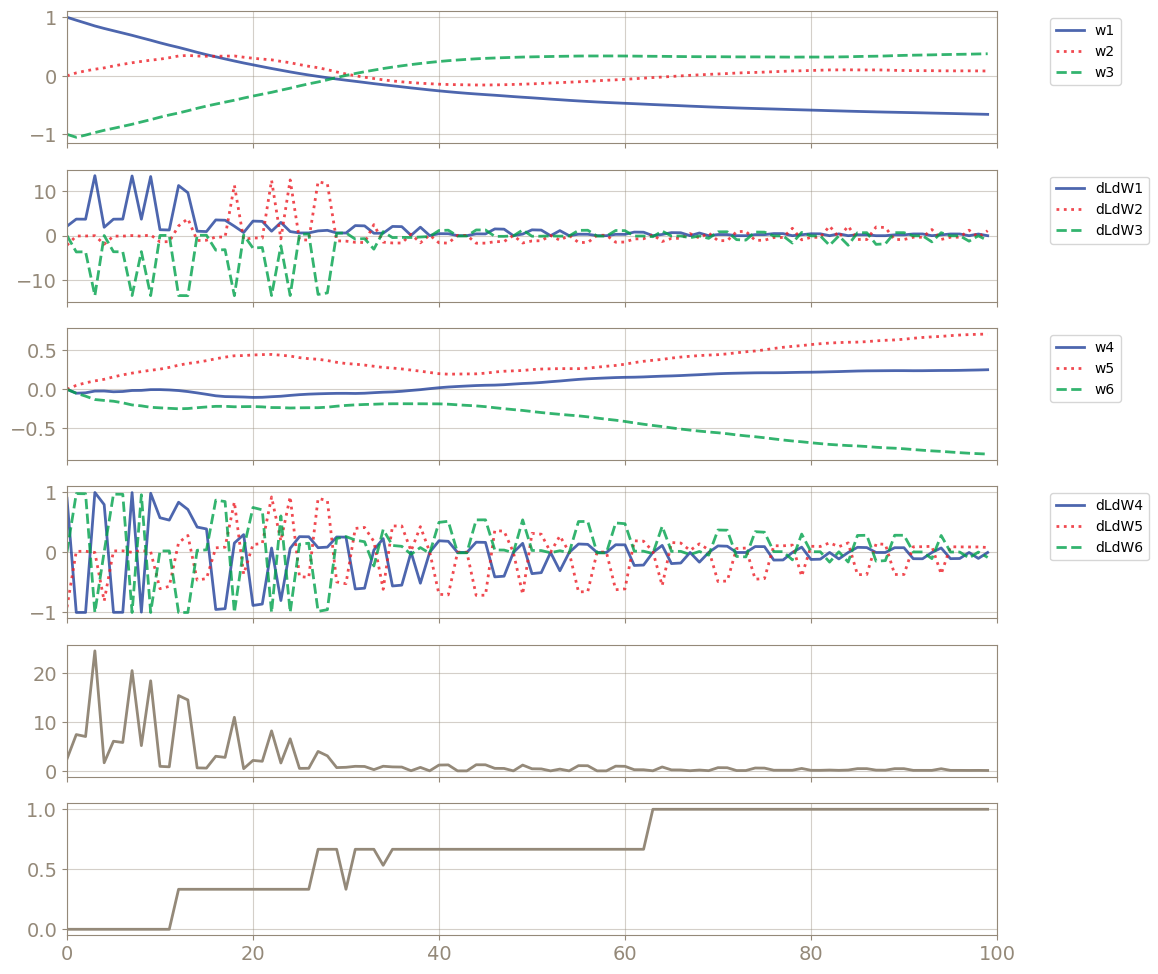

In [123]:
fig=plt.figure(0, (12, 12))
fig.add_subplot(6, 1, 1)
plt.plot(weights[:,0], linewidth=2, color=BLUE, alpha=0.8, label='w1');
plt.plot(weights[:,1], linewidth=2, color=RED, linestyle=':', alpha=0.8, label='w2');
plt.plot(weights[:,2], linewidth=2, color=GREEN, linestyle='--', alpha=0.8, label='w3');
plt.tick_params(labelbottom=False, colors=CHILL_BROWN, labelsize=14)
plt.grid(True, color=CHILL_BROWN, alpha=0.4)
plt.gca().spines['top'].set_color(CHILL_BROWN)
plt.gca().spines['bottom'].set_color(CHILL_BROWN)
plt.gca().spines['left'].set_color(CHILL_BROWN)
plt.gca().spines['right'].set_color(CHILL_BROWN)
plt.xlim([0, 100])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig.add_subplot(6, 1, 2)
plt.plot(grads[:,0], linewidth=2, color=BLUE, alpha=0.8, label='dLdW1');
plt.plot(grads[:,1], linewidth=2, color=RED, linestyle=':', alpha=0.8, label='dLdW2');
plt.plot(grads[:,2], linewidth=2, color=GREEN, linestyle='--', alpha=0.8, label='dLdW3');
plt.tick_params(labelbottom=False, colors=CHILL_BROWN, labelsize=14)
plt.grid(True, color=CHILL_BROWN, alpha=0.4)
plt.gca().spines['top'].set_color(CHILL_BROWN)
plt.gca().spines['bottom'].set_color(CHILL_BROWN)
plt.gca().spines['left'].set_color(CHILL_BROWN)
plt.gca().spines['right'].set_color(CHILL_BROWN)
plt.xlim([0, 100])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig.add_subplot(6, 1, 3)
plt.plot(weights[:,3], linewidth=2, color=BLUE, alpha=0.8, label='w4');
plt.plot(weights[:,4], linewidth=2, color=RED, linestyle=':', alpha=0.8, label='w5');
plt.plot(weights[:,5], linewidth=2, color=GREEN, linestyle='--', alpha=0.8, label='w6');
plt.tick_params(labelbottom=False, colors=CHILL_BROWN, labelsize=14)
plt.grid(True, color=CHILL_BROWN, alpha=0.4)
plt.gca().spines['top'].set_color(CHILL_BROWN)
plt.gca().spines['bottom'].set_color(CHILL_BROWN)
plt.gca().spines['left'].set_color(CHILL_BROWN)
plt.gca().spines['right'].set_color(CHILL_BROWN)
plt.xlim([0, 100])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig.add_subplot(6, 1, 4)
plt.plot(grads[:,3], linewidth=2, color=BLUE, alpha=0.8, label='dLdW4');
plt.plot(grads[:,4], linewidth=2, color=RED, linestyle=':', alpha=0.8, label='dLdW5');
plt.plot(grads[:,5], linewidth=2, color=GREEN, linestyle='--', alpha=0.8, label='dLdW6');
plt.tick_params(labelbottom=False, colors=CHILL_BROWN, labelsize=14)
plt.grid(True, color=CHILL_BROWN, alpha=0.4)
plt.gca().spines['top'].set_color(CHILL_BROWN)
plt.gca().spines['bottom'].set_color(CHILL_BROWN)
plt.gca().spines['left'].set_color(CHILL_BROWN)
plt.gca().spines['right'].set_color(CHILL_BROWN)
plt.xlim([0, 100])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig.add_subplot(6, 1, 5)
plt.plot(losses, linewidth=2, color=CHILL_BROWN)
plt.tick_params(labelbottom=False, colors=CHILL_BROWN, labelsize=14)
plt.grid(True, color=CHILL_BROWN, alpha=0.4)
plt.gca().spines['top'].set_color(CHILL_BROWN)
plt.gca().spines['bottom'].set_color(CHILL_BROWN)
plt.gca().spines['left'].set_color(CHILL_BROWN)
plt.gca().spines['right'].set_color(CHILL_BROWN)
plt.xlim([0, 100])

fig.add_subplot(6, 1, 6)
plt.plot(accuracies, linewidth=2, color=CHILL_BROWN)
plt.tick_params(colors=CHILL_BROWN, labelsize=14)
plt.grid(True, color=CHILL_BROWN, alpha=0.4)
plt.gca().spines['top'].set_color(CHILL_BROWN)
plt.gca().spines['bottom'].set_color(CHILL_BROWN)
plt.gca().spines['left'].set_color(CHILL_BROWN)
plt.gca().spines['right'].set_color(CHILL_BROWN)
plt.xlim([0, 100])

plt.savefig('/Users/stephen/Stephencwelch Dropbox/welch_labs/ai_book/3_backprop_2/graphics/training_plots_1.svg')

(0.0, 100.0)

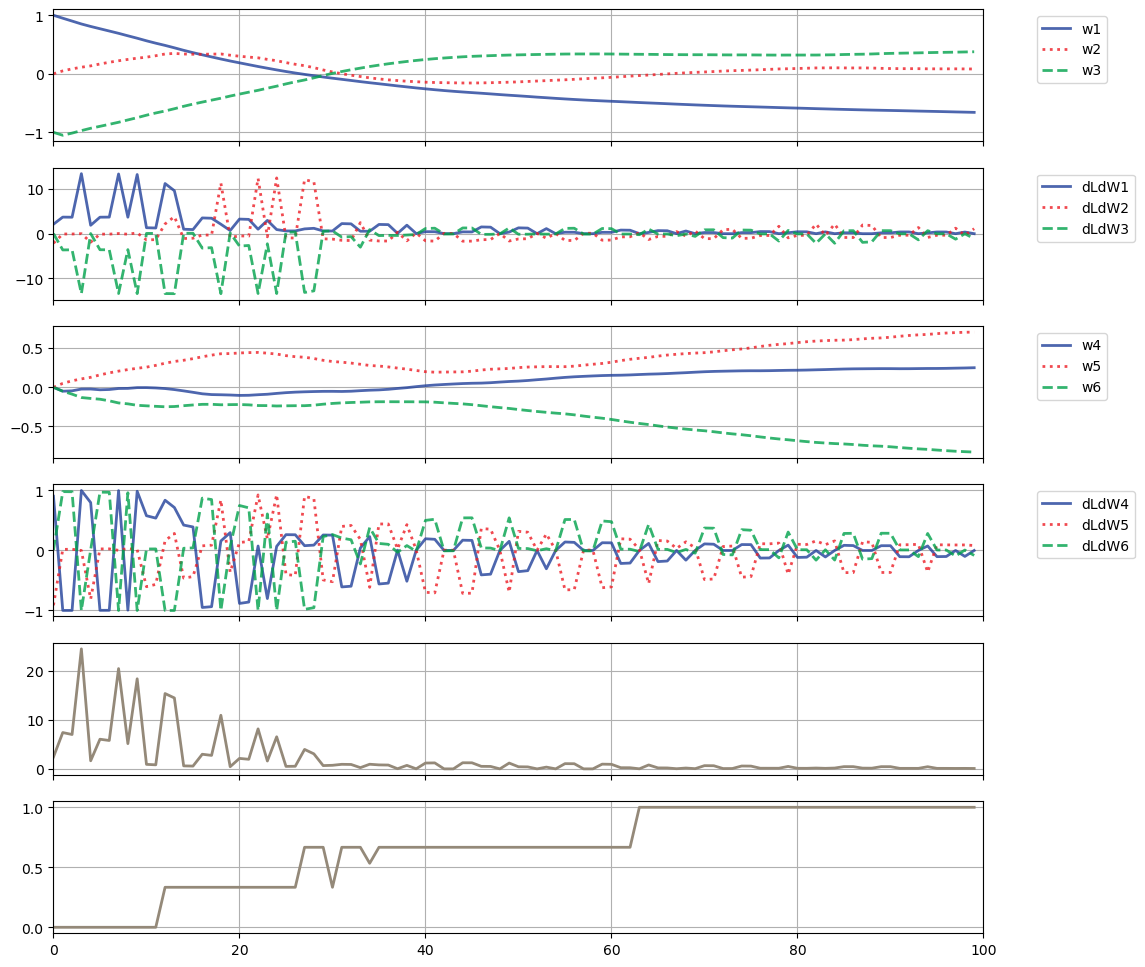

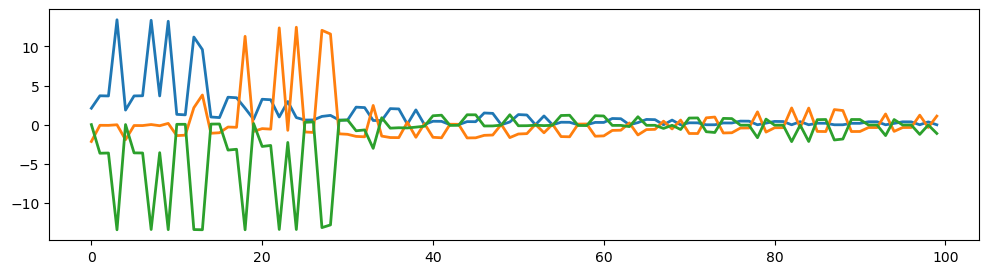

In [81]:
fig=plt.figure(0, (12, 3))
plt.plot(grads[:,:3], linewidth=2);

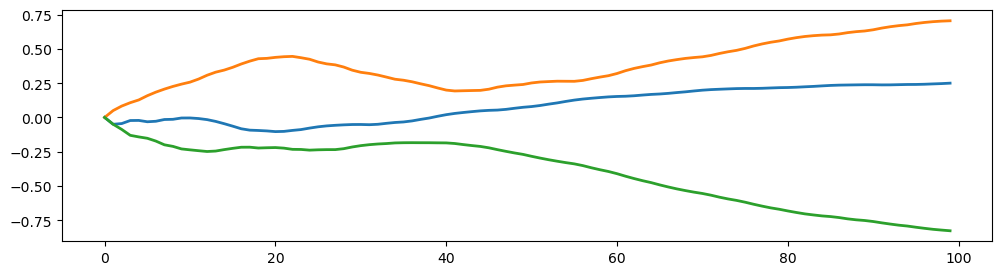

In [80]:
fig=plt.figure(0, (12, 3))
plt.plot(weights[:,3:], linewidth=2);

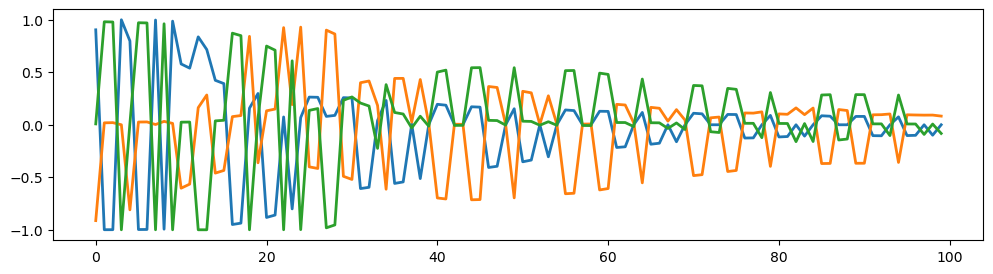

In [79]:
fig=plt.figure(0, (12, 3))
plt.plot(grads[:,3:], linewidth=2);

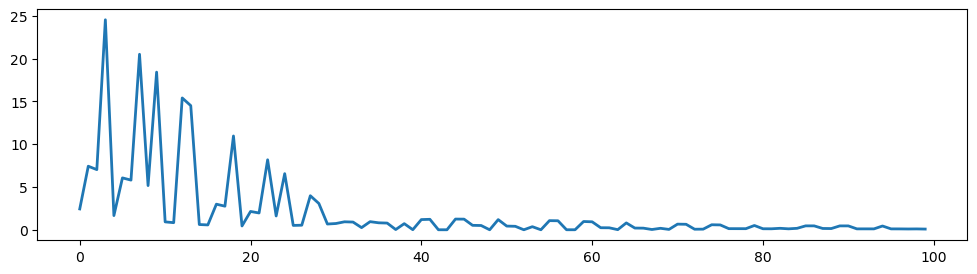

In [66]:
fig=plt.figure(0, (12, 3))
plt.plot(losses, linewidth=2)

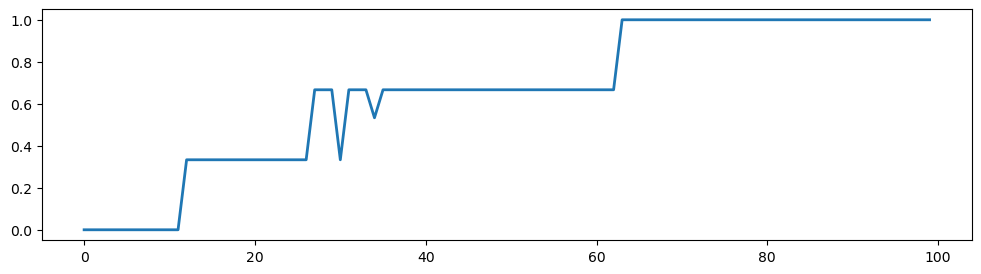

In [78]:
fig=plt.figure(0, (12, 3))
plt.plot(accuracies, linewidth=2)

In [76]:
# plt.plot(yhats);

In [77]:
# plt.plot(logitss);

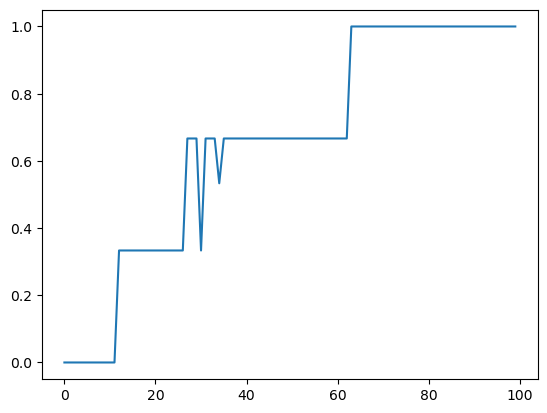

In [52]:
plt.plot(accuracies)

In [32]:
xs[:,1]

array([-3.7033, -3.6835, -3.7143, -3.6921, -3.7033,  2.3514,  2.2945,
        2.3499,  2.3376,  2.3522, 13.405 , 13.3777, 13.4019, 13.3904,
       13.3694, -3.7033, -3.6835, -3.7143, -3.6921, -3.7033,  2.3514,
        2.2945,  2.3499,  2.3376,  2.3522, 13.405 , 13.3777, 13.4019,
       13.3904, 13.3694, -3.7033, -3.6835, -3.7143, -3.6921, -3.7033,
        2.3514,  2.2945,  2.3499,  2.3376,  2.3522, 13.405 , 13.3777,
       13.4019, 13.3904, 13.3694, -3.7033, -3.6835, -3.7143, -3.6921,
       -3.7033,  2.3514,  2.2945,  2.3499,  2.3376,  2.3522, 13.405 ,
       13.3777, 13.4019, 13.3904, 13.3694, -3.7033, -3.6835, -3.7143,
       -3.6921, -3.7033,  2.3514,  2.2945,  2.3499,  2.3376,  2.3522,
       13.405 , 13.3777, 13.4019, 13.3904, 13.3694, -3.7033, -3.6835,
       -3.7143, -3.6921, -3.7033,  2.3514,  2.2945,  2.3499,  2.3376,
        2.3522, 13.405 , 13.3777, 13.4019, 13.3904, 13.3694, -3.7033,
       -3.6835, -3.7143, -3.6921, -3.7033,  2.3514,  2.2945,  2.3499,
        2.3376,  2.3

In [34]:
import pandas as pd

In [43]:
fn='/Users/stephen/Stephencwelch Dropbox/welch_labs/ai_book/3_backprop_2/training_run_1.csv'
pd.DataFrame(weights, columns=['w1', 'w2','w3','b1','b2','b3']).round(3).to_csv(fn)